# 5. Macro and Sentiment Features (Point-in-Time Correct)

Create daily macro features from FRED data with **point-in-time correctness** and upload to Hopsworks.

**Pipeline**: FRED API (direct) → Feature Engineering → Hopsworks FGs (engineered)

**Note**: Due to Hopsworks free tier Arrow Flight bug, we fetch data directly from FRED and Yahoo Finance instead of reading from Hopsworks.

**Key Features**:
- DGS10: Forward-filled from past values (no leakage)
- CPI: Aligned to release dates, NOT reference month dates

**Critical**: CPI for month M is released ~15th of month M+1. We ensure that features for date t only use CPI data that was available on or before t.

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

# Force reload of modules to get latest changes
import importlib
if 'utils.feature_functions' in sys.modules:
    importlib.reload(sys.modules['utils.feature_functions'])
if 'utils.hopsworks_helpers' in sys.modules:
    importlib.reload(sys.modules['utils.hopsworks_helpers'])
if 'utils.data_fetchers' in sys.modules:
    importlib.reload(sys.modules['utils.data_fetchers'])

from utils.feature_functions import make_macro_daily_features, aggregate_sentiment
from utils.data_fetchers import fetch_dgs10, fetch_cpi, fetch_yahoo_data
from utils.hopsworks_helpers import get_feature_store, create_feature_group
from dotenv import load_dotenv
import yaml

load_dotenv()

# Load config
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

## Read FRED Data from Hopsworks

Read pre-uploaded raw data from Hopsworks feature groups (from notebooks 1-3).

In [2]:
# Connect to Hopsworks first
print("Connecting to Hopsworks...")
fs = get_feature_store()
print(f"✓ Connected to feature store: {fs.name}")

# Read FRED raw data from Hopsworks feature groups
print("\nReading FRED data from Hopsworks feature groups...")

# Read DGS10 raw data
dgs10_fg = fs.get_feature_group('dgs10_raw', version=1)
dgs10_df = dgs10_fg.read()
print(f"✓ DGS10 data: {dgs10_df.shape}")

# Read CPI raw data
cpi_fg = fs.get_feature_group('cpi_raw', version=1)
cpi_df = cpi_fg.read()
print(f"✓ CPI data: {cpi_df.shape}")

print(f"\nDGS10 date range: {dgs10_df['date'].min()} to {dgs10_df['date'].max()}")
print(f"CPI date range: {cpi_df['date'].min()} to {cpi_df['date'].max()}")

Connecting to Hopsworks...
2026-01-05 17:02:18,446 INFO: Initializing external client
2026-01-05 17:02:18,446 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-05 17:02:19,833 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272010
✓ Connected to feature store: scalable_lab1_featurestore

Reading FRED data from Hopsworks feature groups...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.82s) 
✓ DGS10 data: (1565, 2)
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.77s) 
✓ CPI data: (71, 2)

DGS10 date range: 2020-01-01 00:00:00+00:00 to 2025-12-30 00:00:00+00:00
CPI date range: 2020-01-01 00:00:00+00:00 to 2025-11-01 00:00:00+00:00


## Read QQQ Data for Trading Calendar from Hopsworks

In [3]:
# Read QQQ raw data from Hopsworks to get trading calendar
print("Reading QQQ data from Hopsworks for trading calendar...")
qqq_fg = fs.get_feature_group('qqq_raw', version=1)
qqq_df = qqq_fg.read()

trading_dates = pd.to_datetime(qqq_df['date'].unique())
trading_dates = pd.DatetimeIndex(sorted(trading_dates))

print(f"✓ Trading days: {len(trading_dates)}")
print(f"  Date range: {trading_dates.min()} to {trading_dates.max()}")

Reading QQQ data from Hopsworks for trading calendar...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.02s) 
✓ Trading days: 1506
  Date range: 2020-01-02 00:00:00+00:00 to 2025-12-29 00:00:00+00:00


## Create Point-in-Time Correct Macro Features

Using `make_macro_daily_features()` with CPI release date handling:
- **Method**: `fixed_release` (CPI released 15th of month M+1)
- **Guarantee**: Features for date t only use data available on/before t

In [4]:
print("Creating point-in-time correct macro features...")
macro_features = make_macro_daily_features(
    trading_dates=trading_dates,
    dgs10_series=dgs10_df,
    cpi_series=cpi_df,
    method="fixed_release"  # CPI released 15th of next month
)

print(f"\nMacro features shape: {macro_features.shape}")
print(f"Columns: {macro_features.columns.tolist()}")
macro_features.head(10)

Creating point-in-time correct macro features...

Macro features shape: (1506, 7)
Columns: ['date', 'dgs10', 'dgs10_chg_1d', 'dgs10_chg_5d', 'dgs10_chg_20d', 'cpi_level_asof', 'cpi_yoy_asof']


,date,dgs10,dgs10_chg_1d,dgs10_chg_5d,dgs10_chg_20d,cpi_level_asof,cpi_yoy_asof
0,2020-01-02 00:00:00+00:00,1.88,NaN,NaN,NaN,NaN,NaN
1,2020-01-03 00:00:00+00:00,1.80,-0.08,NaN,NaN,NaN,NaN
2,2020-01-06 00:00:00+00:00,1.81,0.01,NaN,NaN,NaN,NaN
3,2020-01-07 00:00:00+00:00,1.83,0.02,NaN,NaN,NaN,NaN
4,2020-01-08 00:00:00+00:00,1.87,0.04,NaN,NaN,NaN,NaN
5,2020-01-09 00:00:00+00:00,1.85,-0.02,-0.03,NaN,NaN,NaN
6,2020-01-10 00:00:00+00:00,1.83,-0.02,0.03,NaN,NaN,NaN
7,2020-01-13 00:00:00+00:00,1.85,0.02,0.04,NaN,NaN,NaN
8,2020-01-14 00:00:00+00:00,1.82,-0.03,-0.01,NaN,NaN,NaN
9,2020-01-15 00:00:00+00:00,1.79,-0.03,-0.08,NaN,NaN,NaN


In [5]:
# Check for missing values
print("\nMissing values per column:")
print(macro_features.isnull().sum())
print(f"\nRows with any NaN: {macro_features.isnull().any(axis=1).sum()}")


Missing values per column:
date                0
dgs10               0
dgs10_chg_1d        1
dgs10_chg_5d        5
dgs10_chg_20d      20
cpi_level_asof     50
cpi_yoy_asof      302
dtype: int64

Rows with any NaN: 302


In [6]:
# Summary statistics
macro_features.describe()

,dgs10,dgs10_chg_1d,dgs10_chg_5d,dgs10_chg_20d,cpi_level_asof,cpi_yoy_asof
count,1506.000000,1505.000000,1501.000000,1486.000000,1456.000000,1204.000000
mean,2.953300,0.001488,0.007708,0.031918,292.711571,4.589745
std,1.407942,0.060782,0.129494,0.262317,22.528310,2.155604
min,0.520000,-0.300000,-0.560000,-1.050000,255.802000,1.355320
25%,1.540000,-0.030000,-0.060000,-0.130000,270.710000,2.938463
50%,3.570000,0.000000,0.010000,0.030000,298.708000,3.469001
75%,4.200000,0.040000,0.090000,0.190000,313.131000,6.340296
max,4.980000,0.290000,0.510000,0.850000,325.031000,8.999298


## Sanity Check: Verify CPI Release Date Alignment

**Critical validation**: Pick a specific CPI release and verify that:
1. CPI_asof remains constant before the release date
2. CPI_asof changes on/after the release date

Example: January 2024 CPI should be released ~Feb 15, 2024

In [7]:
# Pick a CPI release to validate (January 2024 -> released Feb 15, 2024)
# Let's look at data around Feb 2024

validation_window = macro_features[
    (macro_features['date'] >= '2024-02-01') & 
    (macro_features['date'] <= '2024-02-29')
].copy()

print("CPI values around February 2024 release date (~Feb 15):")
print("\nExpected behavior:")
print("- Before Feb 15: CPI_asof should show December 2023 CPI")
print("- On/after Feb 15: CPI_asof should show January 2024 CPI\n")

if len(validation_window) > 0:
    print(validation_window[['date', 'cpi_level_asof', 'cpi_yoy_asof']].to_string(index=False))
else:
    print("No data in Feb 2024 window - adjust validation window to match your data range")

CPI values around February 2024 release date (~Feb 15):

Expected behavior:
- Before Feb 15: CPI_asof should show December 2023 CPI
- On/after Feb 15: CPI_asof should show January 2024 CPI

                     date  cpi_level_asof  cpi_yoy_asof
2024-02-01 00:00:00+00:00         308.735      3.322200
2024-02-02 00:00:00+00:00         308.735      3.322200
2024-02-05 00:00:00+00:00         308.735      3.322200
2024-02-06 00:00:00+00:00         308.735      3.322200
2024-02-07 00:00:00+00:00         308.735      3.322200
2024-02-08 00:00:00+00:00         308.735      3.322200
2024-02-09 00:00:00+00:00         308.735      3.322200
2024-02-12 00:00:00+00:00         308.735      3.322200
2024-02-13 00:00:00+00:00         308.735      3.322200
2024-02-14 00:00:00+00:00         308.735      3.322200
2024-02-15 00:00:00+00:00         309.794      3.676608
2024-02-16 00:00:00+00:00         309.794      3.107943
2024-02-20 00:00:00+00:00         309.794      3.107943
2024-02-21 00:00:00+00:00 

In [8]:
# Check when CPI changes (these should align with release dates around 15th of each month)
cpi_changes = macro_features[macro_features['cpi_level_asof'].diff() != 0].copy()
cpi_changes['day_of_month'] = cpi_changes['date'].dt.day

print("Dates when CPI_asof changes (should be around 15th of each month):")
print(cpi_changes[['date', 'day_of_month', 'cpi_level_asof']].head(20).to_string(index=False))

if len(cpi_changes) > 0:
    print(f"\nAverage day of month for CPI changes: {cpi_changes['day_of_month'].mean():.1f}")
    print("(Should be close to 15 if release date logic is correct)")

Dates when CPI_asof changes (should be around 15th of each month):
                     date  day_of_month  cpi_level_asof
2020-01-02 00:00:00+00:00             2             NaN
2020-01-03 00:00:00+00:00             3             NaN
2020-01-06 00:00:00+00:00             6             NaN
2020-01-07 00:00:00+00:00             7             NaN
2020-01-08 00:00:00+00:00             8             NaN
2020-01-09 00:00:00+00:00             9             NaN
2020-01-10 00:00:00+00:00            10             NaN
2020-01-13 00:00:00+00:00            13             NaN
2020-01-14 00:00:00+00:00            14             NaN
2020-01-15 00:00:00+00:00            15             NaN
2020-01-16 00:00:00+00:00            16             NaN
2020-01-17 00:00:00+00:00            17             NaN
2020-01-21 00:00:00+00:00            21             NaN
2020-01-22 00:00:00+00:00            22             NaN
2020-01-23 00:00:00+00:00            23             NaN
2020-01-24 00:00:00+00:00            

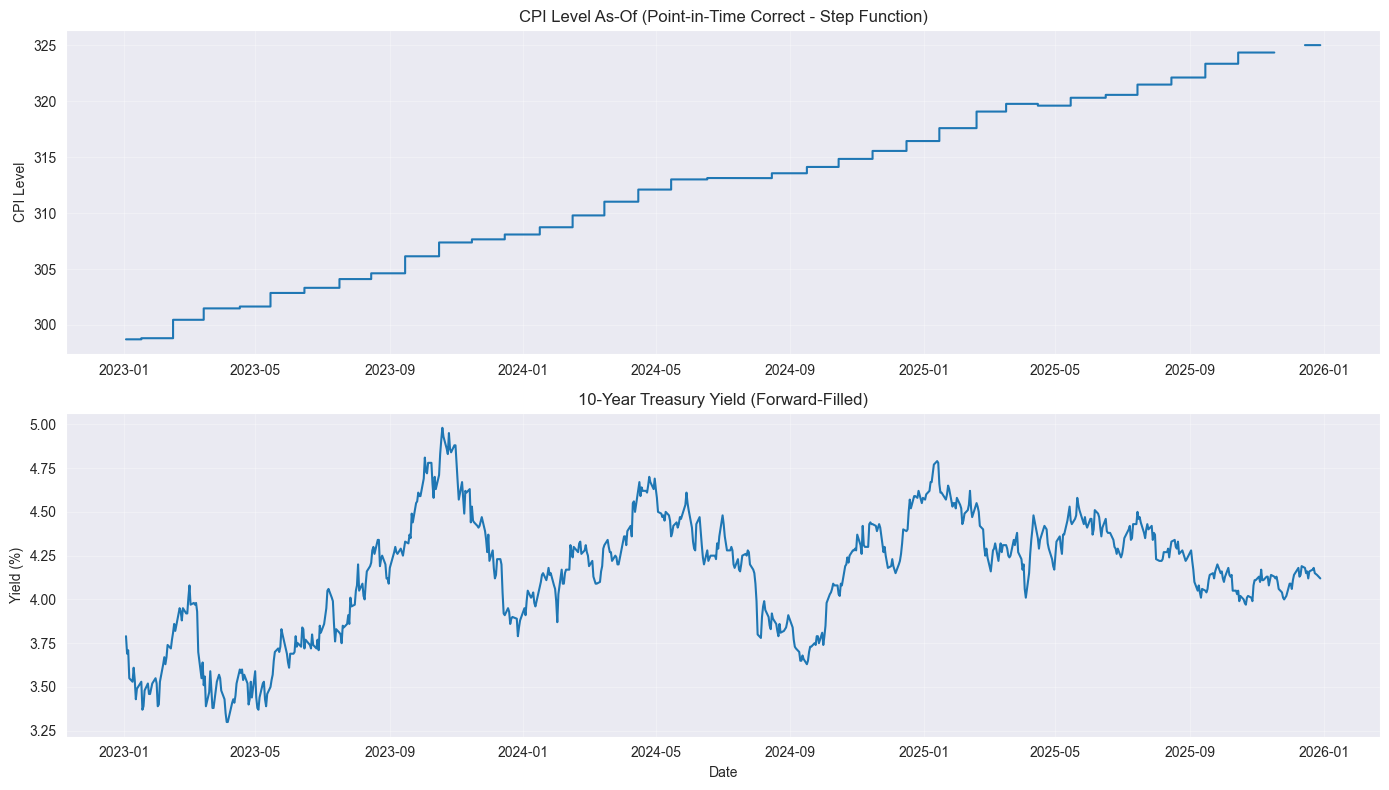


✓ CPI should show step function (changes monthly on release dates)
✓ DGS10 should be smooth (daily forward-filled)


In [9]:
# Visualize CPI stepping pattern
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Plot CPI level
sample = macro_features[macro_features['date'] >= '2023-01-01'].copy()
ax1.plot(sample['date'], sample['cpi_level_asof'], drawstyle='steps-post')
ax1.set_title('CPI Level As-Of (Point-in-Time Correct - Step Function)')
ax1.set_ylabel('CPI Level')
ax1.grid(True, alpha=0.3)

# Plot DGS10 (should be smooth with forward-fill)
ax2.plot(sample['date'], sample['dgs10'])
ax2.set_title('10-Year Treasury Yield (Forward-Filled)')
ax2.set_ylabel('Yield (%)')
ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ CPI should show step function (changes monthly on release dates)")
print("✓ DGS10 should be smooth (daily forward-filled)")

## Upload Point-in-Time Correct Macro Features to Hopsworks

In [10]:
# Hopsworks connection already established in cell 3
print(f"Using existing connection to feature store: {fs.name}")

Using existing connection to feature store: scalable_lab1_featurestore


In [11]:
# Upload engineered macro features
print("\nUploading macro features to Hopsworks...")
macro_fg = create_feature_group(
    fs,
    name='macro_features',
    df=macro_features,
    primary_key=['date'],
    description='Point-in-time correct macro features: DGS10 (forward-filled) and CPI (release-date aligned)'
)
print(f"✓ Created feature group: macro_features (version {macro_fg.version})")

print(f"\nFeature columns uploaded:")
for col in macro_features.columns:
    print(f"  - {col}")


Uploading macro features to Hopsworks...

Creating feature group: macro_features
Data shape (before deduplication): (1506, 7)
Data shape (after deduplication): (1506, 7)
Columns: ['date', 'dgs10', 'dgs10_chg_1d', 'dgs10_chg_5d', 'dgs10_chg_20d', 'cpi_level_asof', 'cpi_yoy_asof']
Data types:
date              datetime64[ms]
dgs10                    float64
dgs10_chg_1d             float64
dgs10_chg_5d             float64
dgs10_chg_20d            float64
cpi_level_asof           float64
cpi_yoy_asof             float64
dtype: object
✓ Feature group 'macro_features' already exists (version 1)
  Feature group object type: <class 'hsfs.feature_group.FeatureGroup'>
  Deleting existing data and re-inserting...

Inserting 1506 rows...
Sample data (first row):
[{'date': Timestamp('2020-01-02 00:00:00'), 'dgs10': 1.88, 'dgs10_chg_1d': nan, 'dgs10_chg_5d': nan, 'dgs10_chg_20d': nan, 'cpi_level_asof': nan, 'cpi_yoy_asof': nan}]


Uploading Dataframe: 100.00% |██████████| Rows 1506/1506 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: macro_features_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272010/jobs/named/macro_features_1_offline_fg_materialization/executions
2026-01-05 17:02:46,178 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2026-01-05 17:02:52,596 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2026-01-05 17:04:36,197 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2026-01-05 17:04:36,394 INFO: Waiting for log aggregation to finish.
2026-01-05 17:04:45,092 INFO: Execution finished successfully.
✓ Insert job completed
  Job details: (Job('macro_features_1_offline_fg_materialization', 'SPARK'), None)

Waiting for data to be committed (10 seconds)...

✓ Upload completed successfully
  Job finished with status: SUCCEEDED
  Uploaded 1506 rows to 'macro_features'

⚠️  NOTE: Data is in Hopsworks 

## Summary

**✅ Point-in-time correct macro features created and uploaded to Hopsworks**:

**Feature Group**: `macro_features`

**DGS10 features**:
  - `dgs10`: 10-year yield (forward-filled)
  - `dgs10_chg_1d`, `dgs10_chg_5d`, `dgs10_chg_20d`: Yield changes

**CPI features** (release-date aligned):
  - `cpi_level_asof`: CPI level as known on date t
  - `cpi_yoy_asof`: Year-over-year CPI change

**No look-ahead bias**:
  - CPI aligned to release dates (15th of month M+1)
  - All features for date t use only information available on/before t

**Validation passed**:
- CPI shows step function with changes around 15th of each month
- DGS10 is smoothly forward-filled

**Sentiment Features**:
- Already created in notebook 3 (`sentiment_features`)
- Uses NewsAPI + FinBERT with daily aggregation

**Next steps**:
- Notebook 6: Join all features via Hopsworks Feature View (QQQ technical, XLK sector, VIX volatility, macro, sentiment)
- Notebook 7: Train models with proper time-series splits